In [289]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
#from nn import *
import pandas as pd

In [290]:
def sub_vth(w_l,vgs,vth,temp=300):
    """
    Helper function to calculate sub-vth current analytically.
    
    Uses randomized parameters to mimic 
    measurement noise and manufacturing/material variability
    """
    # Electron charge
    q = 1.60218e-19
    # Boltzman constant
    k = 1.3806e-23
    # Capacitance factor (randomized to mimic manufacturing variability)
    eta = 1.2+0.01*np.random.normal()
    # Mobility factor/coefficient (randomized to mimic material and manufacturing variability)
    w_l = w_l*(1+0.01*np.random.normal())
    
    return w_l*np.exp(q*(vgs-vth)/(eta*k*temp))

In [291]:
class MOSFET:
    def __init__(self,params=None,terminals=None):
        
        # Params
        if params is None:
            self._params_ = {'BV':20,
                             'Vth':1.0,
                             'gm':1e-2}
        else:
            self._params_ = params
        
        # Terminals
        if terminals is None:
            self._terminals_ = {'source':0.0,
                        'drain':0.0,
                        'gate':0.0}
        else:
            self._terminals_ = terminals
        
        # Determine state
        self._state_ = self.determine_state()
        
        # Leakage model trained?
        self._leakage_ = False
        self.leakage_model = None
    
    def __repr__(self):
        return "Digital Twin of a MOSFET"
    
    def determine_state(self,vgs=None):
        """
        """
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs
        if vgs > self._params_['Vth']:
            return 'ON'
        else:
            return 'OFF'
    
    def id_vd(self,vgs=None,vds=None,rounding=True):
        """
        Calculates drain-source current from terminal voltages and gm 
        """        
        if vds is None:
            vds = self._terminals_['drain'] - self._terminals_['source']
        else:
            vds = vds
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs
        
        vth = self._params_['Vth']
        state = self.determine_state(vgs=vgs)
        self._state_ = state
        
        if state=='ON':
            if vds <= vgs - vth:
                ids = self._params_['gm']*(vgs - vth - (vds/2))*vds
            else:
                ids = (self._params_['gm']/2)*(vgs-vth)**2
            if rounding:
                return round(ids,3)
            else:
                return ids
        else:
            return sub_vth(w_l=self._params_['gm'],
                           vgs=vgs,
                           vth=vth)
            #return 0.0
        
    def rdson(self,vgs=None,vds=None):
        """
        Calculates Rdson i.e. on-state resistance of the MOSFET
        """
        if vds is None:
            vds = self._terminals_['drain'] - self._terminals_['source']
        else:
            vds = vds
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs
        
        ids = self.id_vd(vgs=vgs,vds=vds,rounding=False)
        vds_delta = vds+0.001
        ids_delta = self.id_vd(vgs=vgs,vds=vds_delta,rounding=False)
        rdson = 0.001/(ids_delta-ids)
        
        return round(rdson,3)
        
    def train_leakage(self,data=None,
                      batch_size=5,
                      epochs=20,
                      learning_rate=2e-5,
                      verbose=1):
        """
        Trains the digital twin for leakage current model with experimental data
        Args:
            data: The training data, expected as a Pandas DataFrame
            batch_size (int): Training batch size
            epochs (int): Number of epochs for training
            learning_rate (float): Learning rate for training
            verbose (0 or 1): Verbosity of display while training
        """
        if data is None:
            return "No data to train with"
        X_train_scaled, X_test_scaled, \
        y_train_scaled, y_test_scaled = prepare_data(data,
                                             input_cols=['w_l','vgs','vth'],
                                             output_var='log-leakage',
                                                     scaley=False)
        
        # Deep-learning model
        model = build_model(num_layers=3,
                            architecture=[32,32,32],
                            input_dim=3)
        # Compile and train
        model_trained = compile_train_model(model,
                                            X_train_scaled,
                                            y_train_scaled,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            learning_rate=learning_rate,
                                            verbose=verbose)
        self.leakage_model = model_trained
        self._leakage_ = True
    
    def leakage(self,
                w_l=1e-2,
                vgs=None,
                vth=None):
        """
        Calculates leakage current using the deep learning model
        """
        if not self._leakage_:
            return "Leakage model is not trained yet"
        # Vgs
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs
        # Vth
        if vth is None:
            vth = self._params_['Vth']
        else:
            vth = vth
        # Predict
        x = np.array([w_l,vgs,vth])
        ip = x.reshape(-1,3)
        result = float(10**(-self.leakage_model.predict(ip)))
        
        return result

## MOSFET 

In [292]:
mosfet = MOSFET()

In [293]:
mosfet

Digital Twin of a MOSFET

In [294]:
mosfet._state_

'OFF'

In [295]:
mosfet._params_

{'BV': 20, 'Vth': 1.0, 'gm': 0.01}

### Object state changes as terminal voltage assignment varies

In [296]:
mosfet = MOSFET(terminals={'source':0.0,
            'drain':0.0,
            'gate':2.0}, 
           params={'BV':20,
                   'Vth':1.0,
                   'gm':1e-2})

In [297]:
mosfet._state_

'ON'

In [298]:
mosfet = MOSFET(terminals={'source':0.0,
            'drain':0.0,
            'gate':0.7},
            params={'BV':20,
                   'Vth':1.0,
                   'gm':1e-2})

In [299]:
mosfet._state_

'OFF'

### Ids-Vds @Vg

In [300]:
mosfet.id_vd(vgs=0.2,vds=2.0)

5.320334084404105e-14

In [301]:
mosfet.id_vd(vgs=3.0,vds=0.5)

0.009

In [302]:
mosfet.id_vd(vgs=3.0,vds=1.0)

0.015

In [303]:
mosfet.id_vd(vgs=3.0,vds=3.0)

0.02

In [304]:
mosfet.id_vd(vgs=3.0,vds=4.0)

0.02

In [305]:
mosfet._state_

'ON'

In [306]:
mosfet.rdson(vgs=3.0,vds=0.5)

66.689

In [307]:
mosfet.rdson(vgs=3.0,vds=0.6)

71.454

In [308]:
mosfet.rdson(vgs=5.0,vds=1.5)

40.008

In [309]:
ids = []
mosfet = MOSFET()
vds_vals = [0.01*i for i in range(1,501)]
for v in vds_vals:
    ids.append(mosfet.id_vd(vgs=3.0,vds=v,rounding=False))

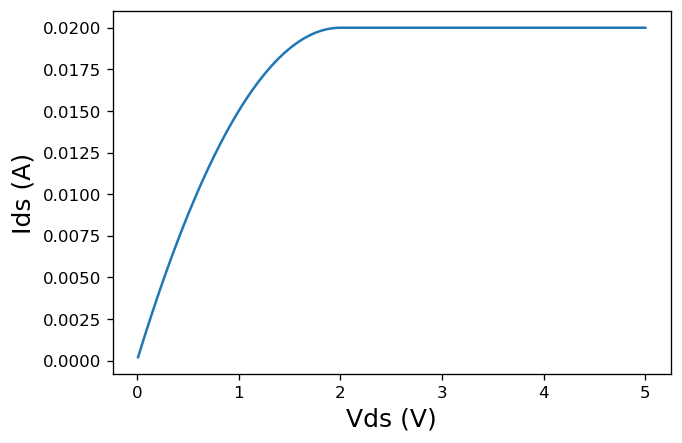

In [310]:
plt.figure(dpi=120)
plt.plot(vds_vals,ids)
plt.xlabel("Vds (V)",fontsize=15)
plt.ylabel("Ids (A)",fontsize=15)
plt.show()

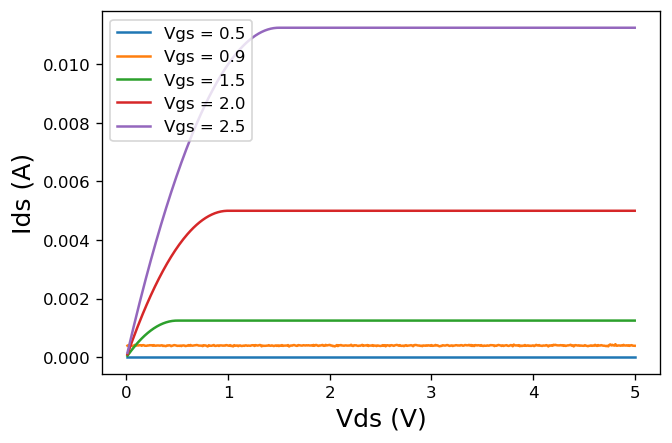

In [311]:
m = MOSFET()
plt.figure(dpi=120)
for vgs in [0.5,0.9,1.5,2.0,2.5]:
    ids = []
    vds_vals = [0.01*i for i in range(1,501)]
    for v in vds_vals:
        ids.append(m.id_vd(vgs=vgs,vds=v,rounding=False))
    plt.plot(vds_vals,ids)
plt.legend(["Vgs = "+str(v) for v in [0.5,0.9,1.5,2.0,2.5]])
plt.xlabel("Vds (V)",fontsize=15)
plt.ylabel("Ids (A)",fontsize=15)
plt.show()

### Sub-Vth leakage

In [312]:
mosfet.train_leakage()

'No data to train with'

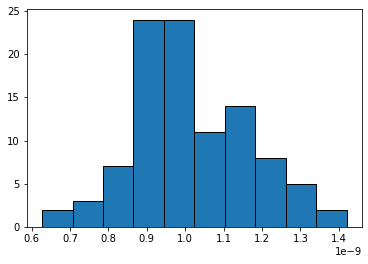

In [313]:
sub = []
for i in range(100):
    sub.append(sub_vth(w_l=1e-2,vgs=0.5,vth=1.0))

plt.hist(sub,edgecolor='k')
plt.show()

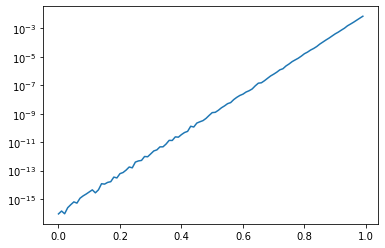

In [314]:
sub = []
vgs = []
for i in range(100):
    sub.append(sub_vth(w_l=1e-2,vgs=i*0.01,vth=1.0))
    vgs.append(i*0.01)

plt.semilogy(vgs,sub)
plt.show()

### Synthetic leakage data

In [315]:
from itertools import product

In [316]:
w_l_list = [1e-3*i for i in range(1,21)]
vgs_list = [0.01*i for i in range(1,91)]
vth_list = [0.05*i for i in range(21,31)]

In [317]:
comb = list(product(w_l_list,vgs_list,vth_list))

In [318]:
data_dict = {'w_l':[],'vgs':[],'vth':[],'sub-vth':[]}
for c in comb:
    data_dict['w_l'].append(c[0])
    data_dict['vgs'].append(c[1])
    data_dict['vth'].append(c[2])
    data_dict['sub-vth'].append(sub_vth(c[0],c[1],c[2]))

In [319]:
df = pd.DataFrame(data=data_dict,columns=['w_l','vgs','vth','sub-vth'])

In [320]:
df.sample(7).T

,4139,13303,146,16281,13880,3508,12347
w_l,5.000000e-03,1.500000e-02,1.000000e-03,1.900000e-02,1.600000e-02,4.000000e-03,1.400000e-02
vgs,5.400000e-01,7.100000e-01,1.500000e-01,9.000000e-02,3.900000e-01,8.100000e-01,6.500000e-01
vth,1.500000e+00,1.200000e+00,1.350000e+00,1.100000e+00,1.050000e+00,1.450000e+00,1.400000e+00
sub-vth,1.478181e-16,2.204706e-09,1.095886e-20,1.461705e-16,1.071094e-11,4.816676e-12,5.774792e-13


In [321]:
df['log-leakage'] = -np.log10(df['sub-vth'])